## Convolve fits spectra from Calspec with LSST detector
=======================================================================

- author : Sylvie Dagoret-Campagne
- creation date July 3rd 2016

The purpose is to view the spectrum of the stars measured in Monocam 

ftp://ftp.stsci.edu/cdbs/current_calspec/


In [184]:
import numpy as np

%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


In [185]:
from astropy.io import fits

In [186]:
import os

In [187]:
path='/Users/dagoret-campagnesylvie/iraf/hdstar_images'

/Users/dagoret-campagnesylvie/iraf/hdstar_images>ls
- hd158485_stis_001.fits	
- hd158485_stis_002.fits	
- hd158485_stis_003.fits
- hd159222_stis_001.fits
- hd159222_stis_002.fits
- hd159222_stis_003.fits
- hd163466_stis_001.fits
- hd163466_stis_002.fits
- hd163466_stis_003.fits

In [188]:
basefilename='hd158485_stis_003.fits'
#basefilename='hd159222_stis_003.fits'
#basefilename='hd163466_stis_002.fits'

In [189]:
file=os.path.join(path,basefilename)

In [190]:
#fits.tabledump(file) # Not working

In [191]:
hdulist=fits.open(file)

In [192]:
hdulist.info()

Filename: /Users/dagoret-campagnesylvie/iraf/hdstar_images/hd158485_stis_003.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   ()              
1    SCI         BinTableHDU     39   4683R x 7C   [1D, 1E, 1E, 1E, 1E, 1I, 1E]   


## Primary extension

In [193]:
#hdulist[0].header

In [194]:
#print hdulist[0].header.keys()

## Secondary extension

In [195]:
#hdulist[1].header

In [196]:
table_data=hdulist[1].data

In [197]:
wavelength=table_data['WAVELENGTH'] # in Angstrom

In [198]:
table_data.columns  # shows the columns names of the table

ColDefs(
    name = 'WAVELENGTH'; format = '1D'; unit = 'ANGSTROMS'; disp = 'G10.4'
    name = 'FLUX'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'STATERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'SYSERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'FWHM'; format = '1E'; unit = 'ANGSTROMS'; disp = 'G6.2'
    name = 'DATAQUAL'; format = '1I'; unit = 'NONE'; disp = 'I2'
    name = 'TOTEXP'; format = '1E'; unit = 'SEC'; disp = 'G10.2'
)

In [199]:
wavelengths=table_data.field('WAVELENGTH')

In [200]:
fluxes=table_data.field('FLUX')

SED_hd158485_stis_003.pdf


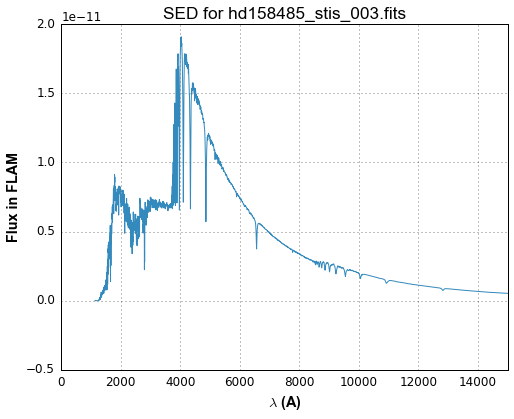

In [201]:
plt.figure(figsize=(8.,6.))
plt.plot(wavelengths,fluxes)
title='SED for {}'.format(basefilename)
figfilename='SED_{}'.format(basefilename.split('.')[0])+'.pdf'
print figfilename
plt.xlabel('$\lambda$ (A)')
plt.ylabel('Flux in FLAM')
plt.title(title)
plt.xlim(0.,15000.)
plt.savefig(figfilename)

In [202]:
indexes_for_sed=np.where( np.logical_and(wavelengths>2000,wavelength<12000))

In [203]:
wavelengths_cut=wavelengths[indexes_for_sed]/10.

In [204]:
fluxes_cut=fluxes[indexes_for_sed]

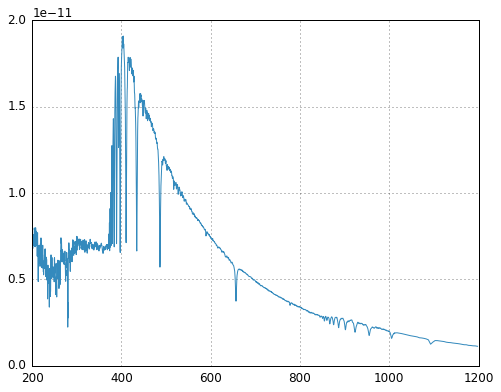

In [205]:
plt.plot(wavelengths_cut,fluxes_cut)

In [206]:
detdatafilename='../LSSTDet/transmissions-LSST.dat'

In [207]:
df=pd.read_csv(detdatafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [208]:
wavelength_det=df['wl']
TCCD=df['Tccd']
Tatm=df['atm']

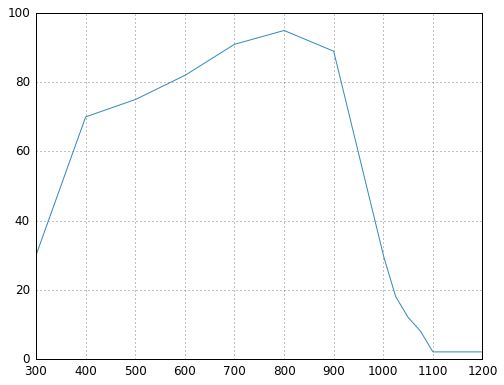

In [209]:
plt.plot(wavelength_det,TCCD) 

In [210]:
from scipy.interpolate import UnivariateSpline

In [211]:
wavelength_to_TCCD_spl= UnivariateSpline(wavelength_det,TCCD)

In [212]:
wavelength_to_atm_spl= UnivariateSpline(wavelength_det,Tatm)

In [213]:
wavelength_to_TCCD_spl(500)

array(76.02655643846114)

In [214]:
TCCD_sed=wavelength_to_TCCD_spl(wavelengths_cut)

In [215]:
Tatm_sed=wavelength_to_atm_spl(wavelengths_cut)

In [216]:
Transmission_atm=TCCD_sed*fluxes_cut*Tatm_sed/100.

In [217]:
Transmission_det=TCCD_sed*fluxes_cut

In [218]:
TCCD_sed

array([-45.38515293, -45.25861531, -45.13215016, ...,   2.04353532,
         2.1134245 ,   2.18127206])

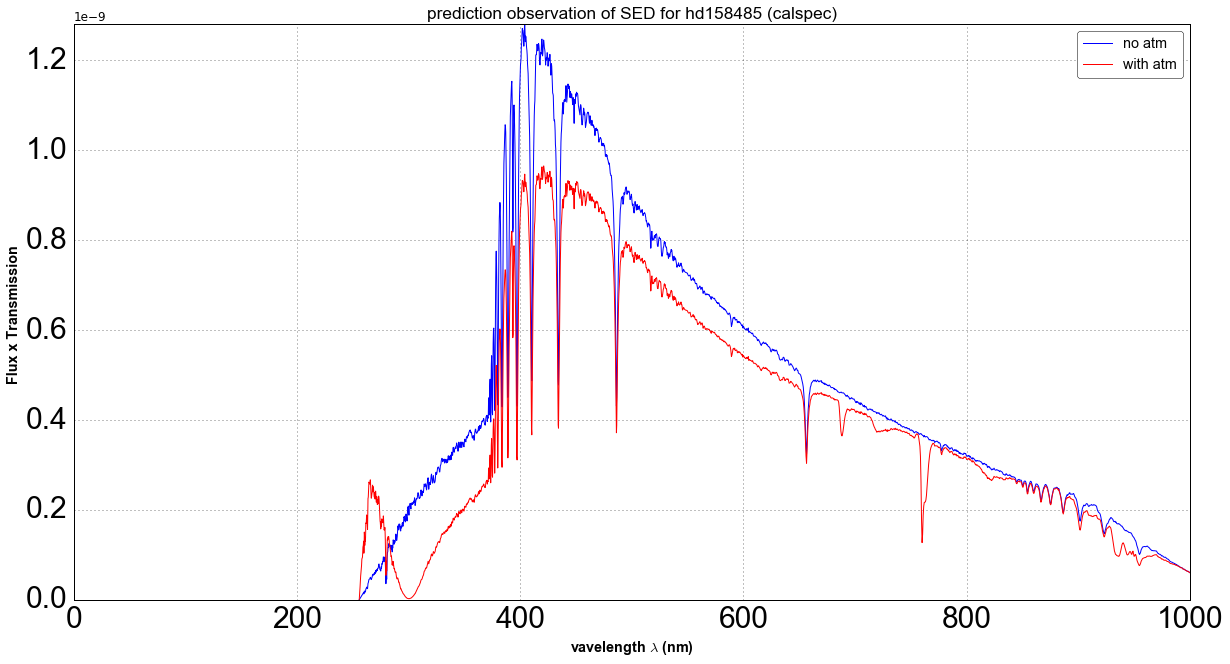

In [228]:
plt.figure(figsize=(20,10))
plt.plot(wavelengths_cut,Transmission_det,label='no atm',color='b')
plt.plot(wavelengths_cut,Transmission_atm,label='with atm',color='r')
plt.xlim(0,1000.)
plt.ylim(0,Transmission_det.max())
plt.title('prediction observation of SED for hd158485 (calspec)')
plt.xlabel('vavelength $\lambda$ (nm)')
plt.ylabel('Flux x Transmission ')
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.legend()
plt.show()